信用卡欺诈检测
本笔记本将对倾斜数据的不同方法进行测试。这个想法是为了比较当绝大多数的类可以破坏我们的预测模型的效率时，预处理技术是否能更好地工作。
您还可以看到如何应用交叉验证来对不同的分类模型进行超参数优化。我的目的是创建模型使用逻辑回归

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

In [12]:
#导入数据
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0,0.5,'Frequency')

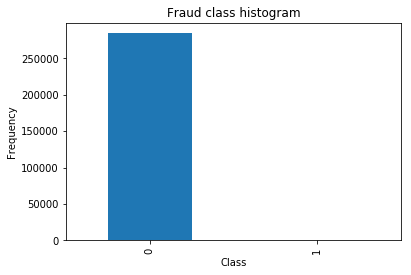

In [13]:
#检查目标类
count_classes = pd.value_counts(data['Class'],sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel('Class')
plt.ylabel("Frequency")

显然数据是完全不平衡的!
这是一个清晰的例子，使用一个典型的精度分数来评估我们的分类算法。例如,如果我们只使用一个多数类赋值所有记录,我们仍将有一个精度高,但是我们会分类所有“1”不正确!
考虑到这种不平衡，有几种方法可以解决这个分类问题。
收集更多的数据?不错的策略，但在这种情况下不适用
改变性能指标:
    利用混沌矩阵计算精度、召回率
    F1score(精度回忆加权平均)
    使用Kappa——这是一种通过数据中类的不平衡而归一化的分类精度
    ROC曲线-计算敏感性/特异性比值。
重采样数据集
    本质上，这是一种处理数据的方法，其比率大约为50% - 50%。
    实现这一点的一种方法是通过过度抽样，即添加代表性不足的类的副本(当您只有很少的数据时，这样做会更好)
    另一种是欠抽样，它从过多表示的类中删除实例(当他有大量数据时更好)

方法
我们不会在第一个实例中执行特性工程。数据集已经降级，以包含30个特性(28个anamised + time + amount)。
然后，我们将比较使用重采样和不使用重采样时的情况。我们将使用一个简单的逻辑回归分类器来测试这种方法。
我们将使用上面提到的一些性能指标来评估模型。
我们将通过调整logistic回归分类器中的参数来重复最好的重采样/不重采样方法。
最后，我们将使用其他分类算法进行分类模型。

设置输入和目标变量+重采样。
1.正常化的金额列。列数量不符合anonimised特性

In [14]:
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data = data.drop(['Time','Amount'], axis = 1)
data.head()

/Users/ls/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


2.赋值X和y，不重采样。
3.重采样。
正如我们前面提到的，有几种方法可以对倾斜数据进行重新采样。除了采样和采样之外，还有一种非常流行的方法，叫做SMOTE(合成少数的超采样技术)，它是超采样和低采样的结合，但是过度采样的方法不是通过复制少数类，而是通过算法构造新的少数类数据实例。

在这个笔记本中，我们将使用传统的欠采样。我可能会尝试在代码的未来版本中实现SMOTE，但是现在我将使用传统的undersamplig。

我们对数据集进行采样的方法是创建一个50/50的比率。这将通过从大多数类中随机选择“x”数量的样本来实现，即“x”是少数类中记录的总数。

In [16]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [21]:
#少数类的数据点数量。
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class ==1].index)

In [22]:
#选择普通类的索引
normal_indices = data[data.Class ==0].index

In [23]:
#从我们选择的索引中，随机选择“x”个(number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

In [24]:
#附加两个索引
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

In [29]:
#在样本数据集中
under_sample_data = data.iloc[under_sample_indices, :]
X_undersample = under_sample_data.iloc[:,under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns =='Class']

In [31]:
#显示比例
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class ==0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class ==1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [32]:
#将数据分割成序列和测试集。计算精度时将使用交叉验证。

In [33]:
from sklearn.cross_validation import train_test_split
#整个数据集
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train) + len(X_test))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807


In [34]:
#欠采样数据集
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample,
                                                                                                   y_undersample,
                                                                                                   test_size = 0.3,
                                                                                                   random_state = 0)
print("")
print("Number transactions train dataet: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+ len(X_test_undersample))


Number transactions train dataet:  688
Number transactions test dataset:  296
Total number of transactions:  984


逻辑回归分类器-抽样不足的数据
我们对召回分数很感兴趣，因为这是一种度量标准，可以帮助我们捕获最欺诈性的交易。如果你认为准确性、精确性和回忆对于混淆矩阵的作用，回忆将是最有趣的:
精度=(TP + TN)/总
精度= TP /(TP + FP)
回忆= TP /(TP + FN)
正如我们所知，由于数据的不平衡性，许多观测结果可以被预测为假阴性，也就是说，我们预测的是正常的交易，但实际上是一场欺诈性的交易。想起了这个。
很明显，试图增加回忆，往往伴随着精度的降低。然而，在我们的案例中，如果我们预测一笔交易是欺诈性的，而事实并非如此，与此相反，这并不是一个大问题。
我们甚至可以应用一个成本函数当FN和FP对于不同类型的误差有不同的权重时，但是我们先把它放在一边。

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve,recall_score, classification_report

In [134]:
#定义函数
def printing_Kfold_scores(x_train_data, y_train_data):
    fold = KFold(len(y_train_data), 5, shuffle=False)
    c_param_range = [0.01, 0.1, 1, 10, 100]
    results_table = pd.DataFrame(index = range(len(c_param_range),2),columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range
# k-fold给出2个列表:train_indices = [0]， test_indices = [1]
    j = 0
    for c_param in c_param_range:
        print('-----------------')
        print('C parameter: ',c_param)
        print('-----------------')
        print('')
        recall_accs = []
        for iteration, indices in enumerate(fold,start = 1):
            #使用特定的C参数调用逻辑回归模型
            lr = LogisticRegression(C = c_param, penalty = 'l1')
            #使用训练数据来适应模型。在这种情况下，我们使用折叠部分来训练模型
            #与指数[0]。然后，我们对[1]指标指定为“测试交叉验证”的部分进行预测
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())
            #使用训练数据中的测试指标预测值
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
            #计算回忆分数，并将其添加到一个包含当前c_parameter的回忆分数的列表中。
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values, y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc )
            #这些回忆分数的平均值是我们想保存和获得的度量。
        results_table.ix[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')
    #转换数字格式
    results_table['Mean recall score'] = results_table['Mean recall score'].astype('float64')
    
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    print(best_c)
    return best_c

In [133]:
best_c = printing_Kfold_scores(X_train_undersample, y_train_undersample)

-----------------
C parameter:  0.01
-----------------

Iteration  1 : recall score =  0.9315068493150684
Iteration  2 : recall score =  0.9178082191780822
Iteration  3 : recall score =  1.0
Iteration  4 : recall score =  0.972972972972973
Iteration  5 : recall score =  0.9545454545454546

Mean recall score  0.9553666992023157

-----------------
C parameter:  0.1
-----------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.863013698630137
Iteration  3 : recall score =  0.9491525423728814
Iteration  4 : recall score =  0.9459459459459459
Iteration  5 : recall score =  0.9090909090909091

Mean recall score  0.9033036329066049

-----------------
C parameter:  1
-----------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.8904109589041096
Iteration  3 : recall score =  0.9830508474576272
Iteration  4 : recall score =  0.9459459459459459
Iteration  5 : recall score =  0.9090909090909091

Mean recall score  0.9

/Users/ls/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Iteration  1 : recall score =  0.8767123287671232
Iteration  2 : recall score =  0.8767123287671232
Iteration  3 : recall score =  0.9830508474576272
Iteration  4 : recall score =  0.9459459459459459
Iteration  5 : recall score =  0.9090909090909091

Mean recall score  0.9183024720057457

0.01


In [138]:
#创建一个函数绘制的混淆矩阵
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix', cmap = plt.cm.Blues):
# 这个函数打印并绘制混淆矩阵。
# 可以通过设置“normalize=True”来应用规范化。
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#打印(“规范化混淆矩阵”)
    else:
        1#打印(“混淆矩阵,没有正常化”)
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment='center', color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

预测测试集和绘制混淆矩阵
我们一直在讨论使用召回度量作为我们预测模型的有效性的代理。尽管回忆仍然是我们想要计算的回忆，但请记住，抽样不足的数据并没有对某个类产生偏倚，这并不表示回忆度量是关键的。

Recall metric in the testing dataset:  0.9183673469387755


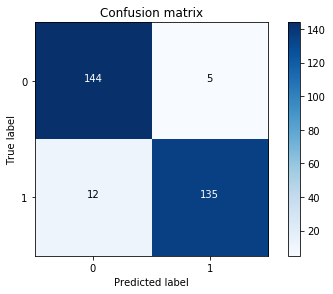

In [139]:
#使用这个C_parameter构建最终的模型，使用整个训练数据集，并预测测试中的类。
#dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)
#计算混淆矩阵
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

#绘制非规范化的混淆矩阵
class_name = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

因此，该模型对一般不可见数据(测试集)的召回准确率为93.8%。这不是第一次尝试的坏百分比。然而，回想一下，这是对抽样不足的测试集的召回准确率的93.8%。
为了对这个结果感到满意，让我们应用我们拟合的模型并对整个数据进行测试。

Recall metric in the testing dataset:  0.9183673469387755


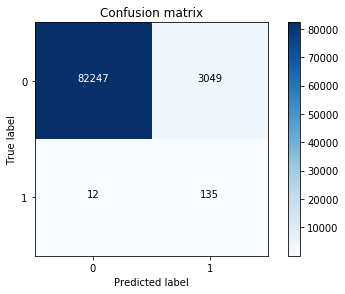

In [140]:
#使用这个C_parameter构建最终的模型，使用整个训练数据集，并预测测试中的类。
#dataset
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)
#计算混淆矩阵
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision = 2)
print('Recall metric in the testing dataset: ', cnf_matrix[1,1]/(cnf_matrix[1,0] + cnf_matrix[1,1]))
#绘制非标准化混淆矩阵
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title = 'Confusion matrix')
plt.show()

当把它应用到更大更倾斜的数据集时，仍然是一个非常不错的回忆精度!
我们可以开始对初始方法的工作方式感到满意。
绘制ROC曲线和精确-回忆曲线。
我发现精确-回忆曲线在这种情况下更方便，因为我们的问题依赖于“积极”类比“消极”类更有趣，但是由于我们计算了回忆精度，我还不打算绘制精确回忆曲线。

AUC和ROC曲线也很有趣，可以检查模型是否也能正确地预测整体，不会产生很多错误

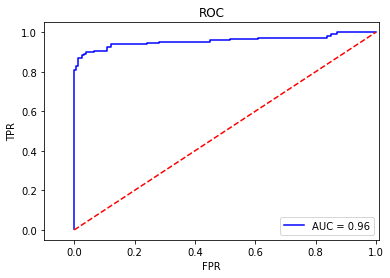

In [130]:
#ROC曲线
lr = LogisticRegression(C = best_c, penalty = 'l1')
y_pred_undersample_score = lr.fit(X_train_undersample,y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)
fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)
#绘制ROC曲线
plt.title('ROC')#Receiver Operating Characteristic接受者操作特征
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'%roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.01])
plt.ylabel('TPR')#True Positive Rate真阳性率
plt.xlabel('FPR')#False Positive Rate假阳性率
plt.show()

另一个有趣的注释是初始化多个未抽样的数据集，并在循环中重复这个过程。记住，要创建一个样本不足的数据，我们随机地从大多数类中获取记录。即使这是一种有效的技术，is也不能表示真正的总体，因此用不同的底样配置重复这个过程，并检查前面选择的参数是否仍然是最有效的。最后，我们的想法是使用整个数据集的更广泛的随机表示，并依赖于平均的最佳参数。
逻辑回归分类器-偏倚数据
在测试了之前的方法之后，我发现在扭曲的数据上测试相同的过程非常有趣。我们的直觉是，偏倚将引入难以捕获的问题，因此提供了一种效率较低的算法。
公平地说，考虑到列车和测试数据集比采样不足的数据集大得多，我认为有必要进行K-fold交叉验证。我想，通过将数据分解成60%的训练集，20%的交叉验证和20%的测试就足够了……但是我们还是用以前的方法(没有什么坏处，只是K-fold在计算上更昂贵)

In [135]:
best_c = printing_Kfold_scores(X_train, y_train)

-----------------
C parameter:  0.01
-----------------

Iteration  1 : recall score =  0.4925373134328358
Iteration  2 : recall score =  0.6027397260273972
Iteration  3 : recall score =  0.6833333333333333
Iteration  4 : recall score =  0.5692307692307692
Iteration  5 : recall score =  0.45

Mean recall score  0.5595682284048672

-----------------
C parameter:  0.1
-----------------



/Users/ls/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Iteration  1 : recall score =  0.5671641791044776
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score =  0.6833333333333333
Iteration  4 : recall score =  0.5846153846153846
Iteration  5 : recall score =  0.525

Mean recall score  0.5953102506435158

-----------------
C parameter:  1
-----------------

Iteration  1 : recall score =  0.5522388059701493
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score =  0.7166666666666667
Iteration  4 : recall score =  0.6153846153846154
Iteration  5 : recall score =  0.5625

Mean recall score  0.612645688837163

-----------------
C parameter:  10
-----------------

Iteration  1 : recall score =  0.5522388059701493
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score =  0.7333333333333333
Iteration  4 : recall score =  0.6153846153846154
Iteration  5 : recall score =  0.575

Mean recall score  0.6184790221704963

-----------------
C parameter:  100
-----------------

Iterati

Recall metric in the testing dataset:  0.6190476190476191


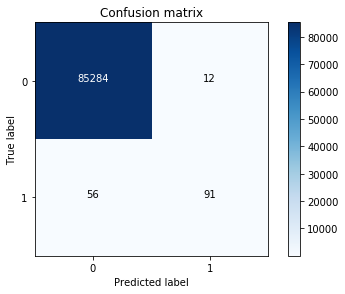

In [141]:
#使用这个C_parameter构建最终的模型，使用整个训练数据集，并预测测试中的类。
#数据集
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train, y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)
#计算混淆矩阵
cnf_matrix = confusion_matrix(y_test, y_pred_undersample)
np.set_printoptions(precision = 2)
print('Recall metric in the testing dataset: ', cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
#绘制非标准化混淆矩阵
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Confusion matrix')
plt.show()

在继续之前……分类阈值的变化。
我们已经看到，通过对数据进行采样，我们的算法在检测欺诈方面做得更好。我还想向大家展示，我们如何通过修改thresell来调整我们的最终分类。
最初，您构建了分类模型，然后使用它预测不可见的数据。
我们以前使用“forecast()”方法来决定记录应该属于“1”还是“0”。
还有另一个方法“predict_proba()”。
该方法返回每个类的概率。这个想法是通过改变阈值将一个记录分配给类1，我们可以控制精度和回忆。
让我们使用未抽样的数据检查一下(最好的C_param = 0.01)

Recall matric in the testing dataset:  1.0
Recall matric in the testing dataset:  1.0
Recall matric in the testing dataset:  1.0
Recall matric in the testing dataset:  0.9659863945578231
Recall matric in the testing dataset:  0.9387755102040817
Recall matric in the testing dataset:  0.8843537414965986
Recall matric in the testing dataset:  0.8163265306122449
Recall matric in the testing dataset:  0.7619047619047619
Recall matric in the testing dataset:  0.6054421768707483


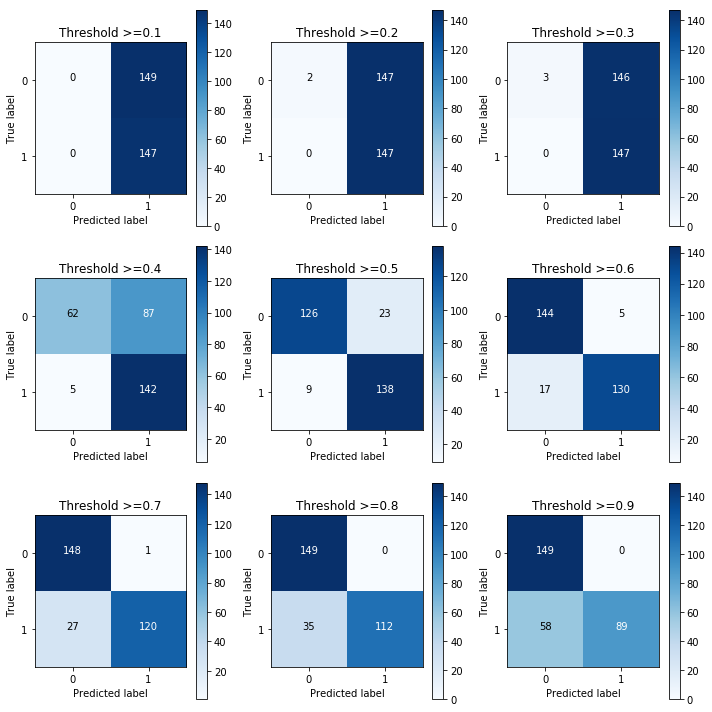

In [142]:
lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(10,10))
j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    plt.subplot(3,3,j)
    j += 1
    #计算混淆矩阵
    cnf_matrix = confusion_matrix(y_test_undersample, y_test_predictions_high_recall)
    np.set_printoptions(precision = 2)
    print('Recall matric in the testing dataset: ', cnf_matrix[1,1]/(cnf_matrix[1,0]+ cnf_matrix[1,1]))
    #绘制混淆矩阵
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix, classes = class_names, title = 'Threshold >=%s'%i)
    

这个模式非常清晰:你越降低在“1”类中放入一个确定的要求的概率，就会有更多的记录被放入这个桶中。
这意味着召回的增加(我们想要所有的“1”)，但与此同时，精确度降低(我们对其他许多类进行了错误的分类)。
因此，即使回忆是我们的目标度量(不要错过一个欺诈交易)，我们也希望模型作为一个整体保持准确。
我认为有一个选项可以很有趣地解决这个问题。我们可以把成本加到错误分类上，但是对“1”分类的兴趣是正确的，错误分类“1”的成本应该大于“0”的错误分类。在此之后，算法将选择最小化总成本的阈值。我看到的一个缺点是我们必须手动选择每个成本的重量。因此，我将把这作为一种思想而留下。
回到阈值变化，有一个选项是精确回忆曲线。通过直观地看到模型的性能取决于我们选择的阈值，我们可以研究一个记忆度足够高的最佳点，同时保持一个高的精度值。
调查Precision-Recall曲线和曲线下的面积

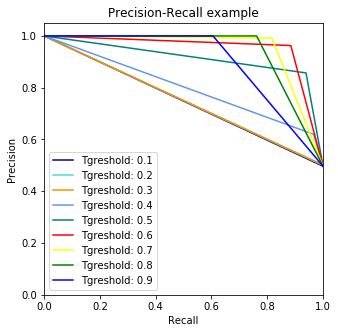

In [154]:
from itertools import cycle
lr = LogisticRegression(C = 0.01, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])
plt.figure(figsize=(5,5))
j =1
for i, color in zip(thresholds, colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    precision, recall, thresholds = precision_recall_curve(y_test_undersample,y_test_predictions_prob)
    #绘制Precision-Recall曲线
    plt.plot(recall, precision, color = color, label = 'Tgreshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc = 'lower left')